# k-Means implementation for SOMLib

### import necessary libraries

In [1]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

## Class definition of own K-Means class

In [2]:
class MyKMeansOnSOMLib:
    """
    MyKMeansOnSOMLib:
        Loads a trained SOM from a SOMLib-UNIT file and 
        performs a k-means clustering on it.
        
        The data file can be state directly here as the parameter "filePath" or later on with the load_data(filePath)-function.
        After loading the data, the k-means algorithm has to be fitted with fit()-function.
        After the fitting step, the clustered SOM can be visualized with the function show_kmeans_plot()-function. 
        
        The k-Means algorithm is from sklearn and has the following parameters:
            n_clusters : int, optional, default: 8
            The number of clusters to form as well as the number of
            centroids to generate.

            init : {'k-means++', 'random' or an ndarray}
                Method for initialization, defaults to 'k-means++':
        
                'k-means++' : selects initial cluster centers for k-mean
                clustering in a smart way to speed up convergence. See section
                Notes in k_init for more details.
        
                'random': choose k observations (rows) at random from data for
                the initial centroids.
        
                If an ndarray is passed, it should be of shape (n_clusters, n_features)
                and gives the initial centers.
        
            n_init : int, default: 10
                Number of time the k-means algorithm will be run with different
                centroid seeds. The final results will be the best output of
                n_init consecutive runs in terms of inertia.
        
            max_iter : int, default: 300
                Maximum number of iterations of the k-means algorithm for a
                single run.
        
            tol : float, default: 1e-4
                Relative tolerance with regards to inertia to declare convergence.
                
            random_state : int, RandomState instance or None (default)
                Determines random number generation for centroid initialization. Use
                an int to make the randomness deterministic.
                See :term:`Glossary <random_state>`.
    """
    
    def __init__(self, k, filePath:str=None, 
                 init='k-means++', n_init=10, max_iter=300, 
                 tol=1e-4, random_state=None):
        
        self.kmeans = KMeans(n_clusters=k, init=init, n_init=n_init,
                 max_iter=max_iter, tol=tol, random_state=random_state)
        self.k = k
        self.init = init
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        
        self.valid_data = False
        self.fitted = False
        self.xdim = 0
        self.ydim = 0
        self.zdim = 0
        self.vec_dim = 0
        self.unit = None
        self.unit_map = None
        self.unit_map_cluster_assignment = None
        self.weight_map = None
        if filePath is not None:
            self.load_files(filePath)
    
    def load_files(self, filePath:str):
        """
        Loads all necessary SOMLib files and created the unit map for the k-means fitting process
        :param filePath: path to the SOMLib-UNIT/-MAP/-WGT files (filename extension not necessary) 
        :return: None
        """
        # check filePath isn't already with the file ending
        if filePath.lower().endswith('.unit') or \
            filePath.lower().endswith('.map') or \
            filePath.lower().endswith('.wgt'):
            filePath = ''.join(filePath.split('.')[:-1])
        # load data from the unit file
        self._load_unit_file(filePath) 
        #self._load_wgt_file(filePath)
        #self._load_map_file(filePath)
        
        # create unit map only with cells which got points on them
        self._create_unit_map() 
        # set check boolean if data is correctly loaded to True
        self.valid_data = True
        # set check boolean if data is correctly fitted to False
        self.fitted = False
        
    def fit(self, weighted=True):
        """
        Fits the k-Means algorithm to the previously loaded SOMLib files.
        
        Throws exception if SOMLib files are not loaded. 
        :param weighted: boolean, default=True, If True fits the k-Means algorithm with the weighted cell, this means that more dense cells have a higher weight.
        :return: None 
        """
        if not self.valid_data:
            raise Exception("The data files need to be loaded before fitting the k-means clusters! Use load_files(filePath:str)!")
        
        if weighted:
            # if weighted boolean is set the number of points per cell are indicates the "mass" of each cell
            self.unit_map_cluster_assignment = \
                self.kmeans.fit_predict(self.unit_map, sample_weight=self.weight_map)
        else:
            # number of point per cell is ignored, each cell that has at least 1 point on it counts the same
            self.unit_map_cluster_assignment = \
                self.kmeans.fit_predict(self.unit_map)
        # set check boolean if data is correctly fitted to True
        self.fitted = True
    
    def get_cluster_centers(self):
        """
        Returns the centers for the trained clusters.
        
        Throws exception if the k-Means algorithm is not fitted.
        :return: array-like shape(k,)
        """
        if not self.fitted:
            raise Exception("The k-means clusters need to be fitted before getting the centers! Use fit()!")
        return self.kmeans.cluster_centers_
    
    def get_kmeans_plot(self, title=None, grid=True, density=True, link_clusters=True, threshold=0.6):
        """
        Returns the plot with all centers of the k clusters and 
        their assigned cells as well as its 
        relative density to the most dense cell.
          
        :param density: boolean, default=True, If true shows the relative density to the most dense cell
        :param threshold: float, >=0, indicates how dense a neighbor has to be in respect to the median of the own cluster to get linked together
        :param link_clusters: boolean, default=Flase, If true shows the cluster which are defined as linked in the same color
        :param grid: boolean, default=True, If true show grid lines between cells
        :return: Plot
        """
        if not self.fitted:
            raise Exception("The k-means clusters need to be fitted before plotting! Use fit()!")
        plt.figure(figsize=(10,10))
        # gets the default 10 color cycle from pyplot for coloring cluster centers and assigned points in the same color (and as well linked clusters)
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        plt.xlim(0 - 0.5, self.xdim - 0.5)
        plt.ylim(0 - 0.5, self.ydim - 0.5)
        plt.xticks(np.arange(0, self.xdim, 1))
        plt.yticks(np.arange(0, self.ydim, 1))
        
        
        if link_clusters:
            # linked_clusters (n_clusters, None), contains for each cluster all neighbors
            linked_clusters = self.get_linked_cluster(threshold=threshold)
            linked_colors = np.empty(self.k, dtype='object')
            color = 0
            # set give the current cluster and all its neighbors the current color (if he hasn't already a color) 
            for cluster_id in range(self.k):
                if linked_colors[cluster_id] is None:
                    linked_colors[cluster_id] = colors[color % len(colors)]
                    for linked_cluster in linked_clusters[cluster_id]:
                        linked_colors[linked_cluster] = colors[color % len(colors)]
                    color += 1
        
        # colors only a proportion of the cell - proportion is dependent on the ratio between the cell and the cell with the highest density
        max_dense_cell = np.max(self.weight_map)
        for cluster_id in range(self.k):
            if not density:
                ratio = np.ones(len(self.unit_map))
            else:
                # sqrt is used because x and y axis get muliplied by ratio
                ratio = np.sqrt(1. / max_dense_cell * \
                        self.weight_map[self.unit_map_cluster_assignment == cluster_id])
            for unit_id, unit in \
                enumerate(self.unit_map[self.unit_map_cluster_assignment == cluster_id]):
                plt.fill_between([unit[0] - (0.5 * ratio[unit_id]), 
                                  unit[0] + (0.5 * ratio[unit_id])], 
                                 [unit[1] - (0.5 * ratio[unit_id]), 
                                  unit[1] - (0.5 * ratio[unit_id])], 
                                 [unit[1] + (0.5 * ratio[unit_id]), 
                                  unit[1] + (0.5 * ratio[unit_id])],
                                 color= ((colors[cluster_id % len(colors)]) 
                                         if not link_clusters else 
                                         (linked_colors[cluster_id])))
        
        # draws the grid
        if grid:
            for v in range(self.xdim):
                plt.plot([v - 0.5, v - 0.5], [0 - 0.5, self.ydim - 0.5], color="black", linewidth=2)
            for h in range(self.ydim):
                plt.plot([0 - 0.5, self.xdim - 0.5], [h - 0.5, h - 0.5], color="black", linewidth=2)
        
        # draws the cluster centers in the color of the custer assigned cells
        for cluster_id, cluster_center in enumerate(self.get_cluster_centers()):
            plt.plot(cluster_center[0], cluster_center[1], 
                     color=colors[cluster_id % len(colors)] 
                            if not link_clusters else
                            linked_colors[cluster_id],
                     markersize=20 if cluster_id < 10 else 30, 
                     markeredgewidth=0.5, marker="$x_{" + str(cluster_id+1) + "}$", 
                     label="Cluster {}".format(cluster_id+1),
                     markeredgecolor='black', fillstyle='full')
        
        plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
        if title is not None: plt.title(title)
        return plt
        
    def get_linked_cluster(self, threshold=0.75):
        """
        Returns an array for each cluster in that all clusters appear,
        which have a neighbor and has a higher density at the neighbors than 
        threshold * median of the cluster.
        Afterwards all neighbors of the neighbors get aswell neighbors.
        
        :param threshold: threshold what dense a neighbor has to have to be a neighbor 
        :return: (k, <=k) for each cluster all neighbors, neighbor-neighbors, etc.
        """
        median_weights = [] 
        assignments = []
        # calculate the median density for each clusters and multiply it by the threshold
        for cluster_id in range(self.k):
            assignments.append([])
            median_weights.append(np.median(
                self.weight_map[self.unit_map_cluster_assignment == cluster_id])
                                  * threshold)
        # check for each cell if it has a neighbor from a different cluster that is big enouth, if so add it to the link list
        for unit_id, unit in enumerate(self.unit_map):
            assignment = self.unit_map_cluster_assignment[unit_id]
            if self.weight_map[unit_id] >= median_weights[assignment]:
                for x in [0, -1, 1]:
                    for y in [0, -1, 1]:
                        result =(self.unit_map == np.array([unit[0] + x, unit[1] + y, unit[2]])).all(axis=1).nonzero()
                        if len(result[0]) != 0 and \
                            assignment != self.unit_map_cluster_assignment[result[0][0]] \
                            and self.weight_map[result[0][0]] >= median_weights[assignment]:
                                assignments[assignment].append(self.unit_map_cluster_assignment[result[0][0]])
        # make each entry in the link list unique
        for assignment_id in range(len(assignments)):
            assignments[assignment_id] = list(np.unique(assignments[assignment_id]))
        # add the own link list to each neighbor, and make the entrys of the list of the neighbor unique to avoid endless loops
        for assignment_id in range(len(assignments)):
            for ass in assignments[assignment_id]:
                assignments[ass].extend(assignments[assignment_id])
                assignments[ass] = list(np.unique(assignments[ass]))
        for assignment_id in range(len(assignments)):
            assignments[assignment_id] = list(np.sort(np.unique(assignments[assignment_id])))
        return assignments
        
    def _create_unit_map(self):
        """
        Internal method to create the unit map, 
        which is needed for the fitting of the k means algorithm
        :return: None 
        """
        unit_map = []
        weight_map = []
        # create the map with only cells that are non empty
        for cell in self.unit:
            if cell['nr_vec_mapped'] != 0:
                unit_map.append([cell['x'], cell['y'], cell['z']])
                weight_map.append(cell['nr_vec_mapped'])
        self.unit_map = np.array(unit_map)
        self.weight_map = np.array(weight_map)
     
    def _load_unit_file(self, filePath:str):
        """
        Internal Method to load the SOMLib UNIT-file.
        :param filePath: path to the SOMLib UNIT-file without the file extension
        :return: None
        """
        try:
            with open(filePath + '.unit', 'r') as file:
                self.unit = []
                
                x, y, z = -1, -1, -1
                unit_id = ""
                quanterror_unit, quanterror_unit_avg = -1., 0.
                nr_vec_mapped = -1
                mapped_vecs = []
                mapped_vecs_dist = []
                
                for line in file:
                    # skip comments or not needed information
                    if line[0] == '#' or \
                            line.lower().startswith('$type') or \
                            line.lower().startswith('$file_format_version') or \
                            line.lower().startswith('$mapped_vecs\n'):
                        continue
                    # read global constants
                    elif line.lower().startswith('$xdim'):
                        self.xdim = int(line.strip().split(' ')[-1])
                    elif line.lower().startswith('$ydim'):
                        self.ydim = int(line.strip().split(' ')[-1])
                    elif line.lower().startswith('$zdim'):
                        self.zdim = int(line.strip().split(' ')[-1])
                    elif line.lower().startswith('$vec_dim'):
                        self.vec_dim = int(line.strip().split(' ')[-1])
                    # read cell constants 
                    elif line.lower().startswith('$pos_x'):
                        x = int(line.strip().split(' ')[-1])
                    elif line.lower().startswith('$pos_y'):
                        y = int(line.strip().split(' ')[-1])
                    elif line.lower().startswith('$pos_z'):
                        z = int(line.strip().split(' ')[-1])
                    elif line.lower().startswith('$unit_id'):
                        unit_id = line.strip().split(' ')[-1]
                    elif line.lower().startswith('$quanterror_unit'):
                        quanterror_unit = float(line.strip().split(' ')[-1])
                    elif line.lower().startswith('$quanterror_unit_avg'):
                        quanterror_unit_avg = float(line.strip().split(' ')[-1])
                    
                    # a cell is done either if its empty after the number of assigen vectors, or if its not empty after the mapped vector distances
                    elif line.lower().startswith('$nr_vec_mapped'):
                        nr_vec_mapped = int(line.strip().split(' ')[-1])
                        if nr_vec_mapped is 0:
                            self._add_to_unit(unit_id=unit_id, x=x, y=y, z=z, 
                                          quanterror_unit=quanterror_unit, 
                                          quanterror_unit_avg=quanterror_unit_avg, 
                                          nr_vec_mapped=nr_vec_mapped, 
                                          mapped_vecs=mapped_vecs, 
                                          mapped_vecs_dist=mapped_vecs_dist)
                            x, y, z = -1, -1, -1
                            unit_id = ""
                            quanterror_unit, quanterror_unit_avg = -1., 0.
                            nr_vec_mapped = -1
                            mapped_vecs = []
                            mapped_vecs_dist = []
                    elif line.lower().startswith('$mapped_vecs_dist'):
                        mapped_vecs_dist.append(list(map(float, line.strip().split(' ')[1:])))
                        self._add_to_unit(unit_id=unit_id, x=x, y=y, z=z, 
                                          quanterror_unit=quanterror_unit, 
                                          quanterror_unit_avg=quanterror_unit_avg, 
                                          nr_vec_mapped=nr_vec_mapped, 
                                          mapped_vecs=mapped_vecs, 
                                          mapped_vecs_dist=mapped_vecs_dist)
                        x, y, z = -1, -1, -1
                        unit_id = ""
                        quanterror_unit, quanterror_unit_avg = -1., 0.
                        nr_vec_mapped = -1
                        mapped_vecs = []
                        mapped_vecs_dist = []
                    else:
                        # the assigned vertices are not indicated by a line beginning and are a reference to the index
                        mapped_vecs.append(int(line.strip()))
        except OSError:
            raise Exception('File {} couldn\'t be opened'.format(filePath + '.map'))
        
    def _add_to_unit(self, unit_id, x, y, z, quanterror_unit, 
                     quanterror_unit_avg, nr_vec_mapped, mapped_vecs, 
                     mapped_vecs_dist):
        """
        Creates a UNIT with all properties from the SOMLib UNIT-file and adds it to the units-List
        :param unit_id: unit_id of the unit
        :param x: X-coordinate of the unit
        :param y: Y-coordinate of the unit
        :param z: Z-coordinate of the unit
        :param quanterror_unit: Quant error of the unit
        :param quanterror_unit_avg: Average quant error of the unit
        :param nr_vec_mapped: Number of mapped vertices to this unit
        :param mapped_vecs: List of mapped vertices of the unit
        :param mapped_vecs_dist: List of the mapped vertices distance
        :return: None
        """
        self.unit.append({
            'unit_id': unit_id,
            'x': x,
            'y': y, 
            'z': z,
            'quanterror_unit': quanterror_unit,
            'quanterror_unit_avg': quanterror_unit_avg,
            'nr_vec_mapped': nr_vec_mapped,
            'mapped_vecs': mapped_vecs,
            'mapped_vecs_dist': mapped_vecs_dist
        })
    
    def _load_wgt_file(self, filePath:str):
        """
        Loads the SOMLib WGT-file:
        ATTENTION: Currently not implemented!
        :param filePath: path to the SOMLib WGT-file without the file extension
        :return: None
        """
        try:
            with open(filePath + '.wgt', 'r') as file:
                for line in file:
                    if line[0] == '#' or line.lower().startswith('$type'):
                        continue
                    elif line.lower().startswith('$xdim'):
                        self.xdim = int(line.strip().split(' ')[-1])
                    elif line.lower().startswith('$ydim'):
                        self.ydim = int(line.strip().split(' ')[-1])
                    elif line.lower().startswith('$zdim'):
                        self.zdim = int(line.strip().split(' ')[-1])
                    elif line.lower().startswith('$vec_dim'):
                        self.vec_dim = int(line.strip().split(' ')[-1])
                    else:
                        #the rest is not implemented as it is not needed
                        raise NotImplemented()                       
        except OSError:
            raise Exception('File {} couldn\'t be opened'.format(filePath + '.map'))

    def _load_map_file(self, filePath:str):
        """
        Loads the SOMLib MAP-file:
        ATTENTION: Currently not implemented!
        :param filePath: path to the SOMLib MAP-file without the file extension
        :return: None
        """
        try:
            raise NotImplemented()
        except OSError:
            raise Exception('File {} couldn\'t be opened'.format(filePath + '.map'))
    

## Example section

### provide some static variables

In [3]:
path_10clusters = 'data/10clusters/output/10clusters'
path_chainlink = 'data/chainlink/output/chainlink'
path_10clusters_own = 'data/10clusters/output/10clusters_{}_{}_{}_{}_pca'
path_chainlink_own = 'data/chainlink/output/chainlink_{}_{}_{}_{}_pca'

sizes = [(20, 25), (100, 60)]
sigmas = [0.1, 2.3, 10]
learning_rates = [0.01, 0.2, 5]

### 10clusters dataset

In [4]:
clusters_kmeans_20 = MyKMeansOnSOMLib(k=20, n_init=100, max_iter=10000, random_state=42)
clusters_kmeans_20.load_files(filePath=path_10clusters)
clusters_kmeans_20.fit()

As you can clearly see using 20 clusters for the 10-Cluster works pretty good with the k-means cluster linkage tool.

Also you can observe that only the very small clusters on one or at most 2 cells are covered by only one k-means cluster, the medium sized ones have mostly 3 k-means clusters and largest one is by 7 clusters covered.  

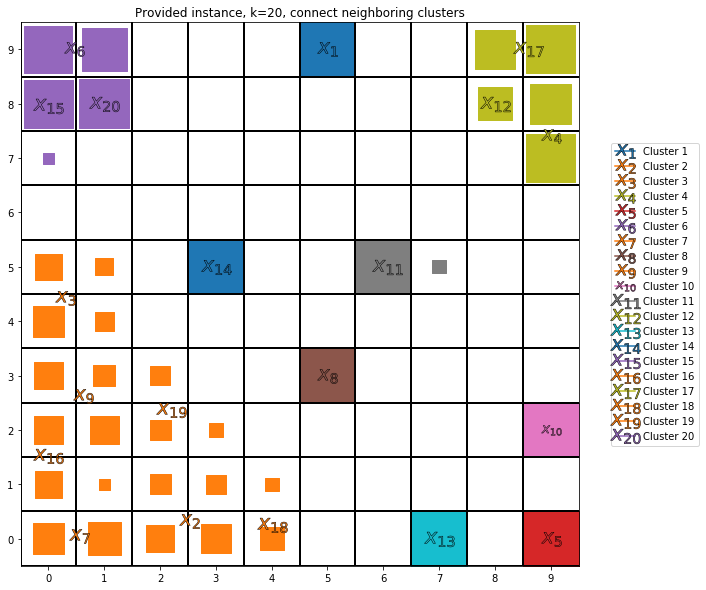

In [5]:
clusters_kmeans_20.get_kmeans_plot(title="Provided instance, k=20, connect neighboring clusters", grid=True, density=True, link_clusters=True, threshold=0.7).show()

In [6]:
clusters_kmeans_10 = MyKMeansOnSOMLib(k=10, n_init=1000, max_iter=10000, random_state=42)
clusters_kmeans_10.load_files(filePath=path_10clusters)
clusters_kmeans_10.fit()

Here you can see, if we only use 10 k-means clusters we can't cover all clusters correctly.

Again the largest cluster needs more than 1 k-means clustern and therefore there are not enough k-means clusters left to cover the remaining properly. 

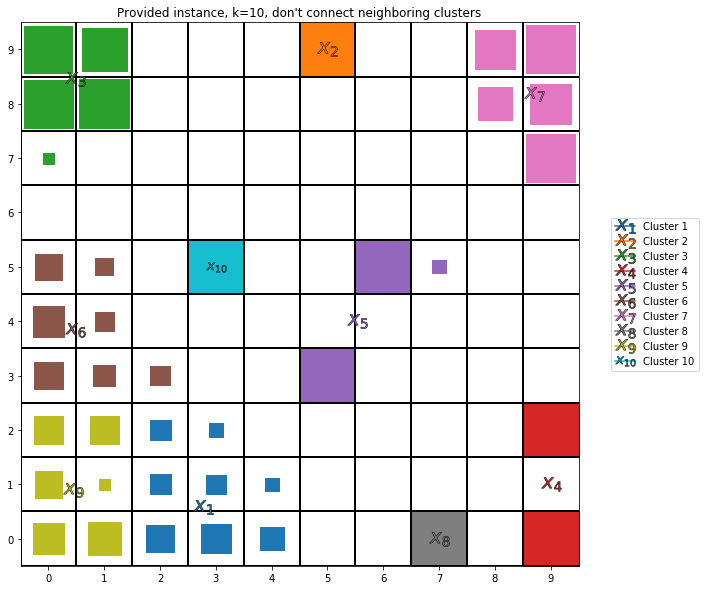

In [7]:
clusters_kmeans_10.get_kmeans_plot(title="Provided instance, k=10, don't connect neighboring clusters", grid=True, density=True, link_clusters=False, threshold=0.7).show()


### chainlink dataset

In [8]:
chainlink_kmeans = MyKMeansOnSOMLib(k=10, n_init=100, max_iter=10000, random_state=42)
chainlink_kmeans.load_files(filePath=path_chainlink)
chainlink_kmeans.fit()

Here we have as well 10 k-means clusters which seems fairly enough for the two circles, but since all k-means clusters are far away from each other the grey cluster in the middle covers parts from both circles.

If we would use in this example the linkage tool, everything would end up in the same cluster, or if the threshold is high enough most clusters stay still separated.

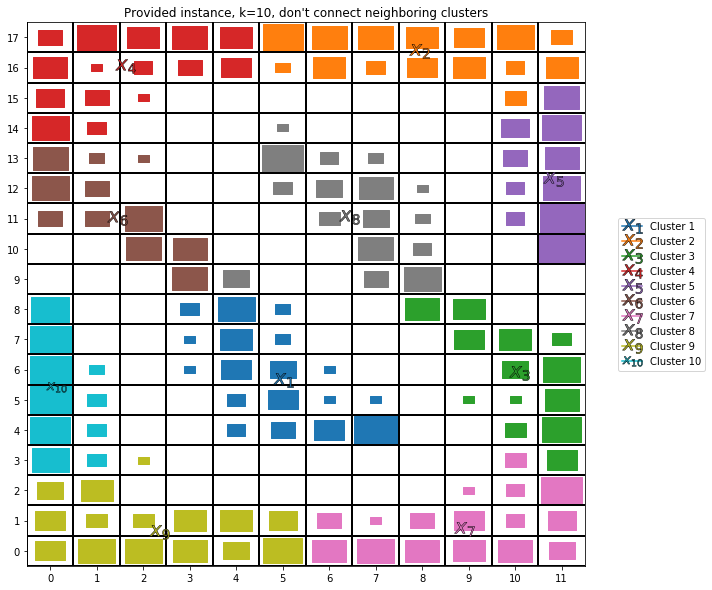

In [9]:
chainlink_kmeans.get_kmeans_plot(title="Provided instance, k=10, don't connect neighboring clusters", grid=True, density=True, link_clusters=False, threshold=1.2).show()

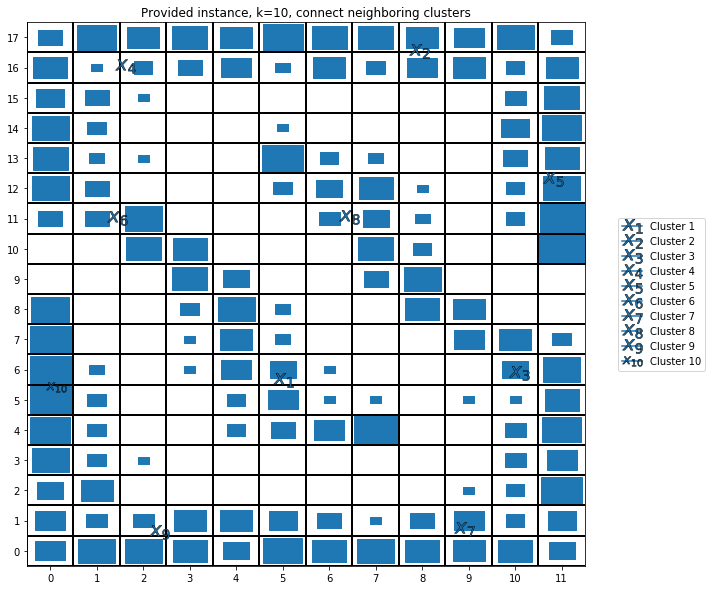

In [11]:
chainlink_kmeans.get_kmeans_plot(title="Provided instance, k=10, connect neighboring clusters", grid=True, density=True, link_clusters=True, threshold=0.6).show()


## own trained SOMs
### chainlink

If the sigma wasn't high enough then it is possible that most points end up in the same cell and the k means algorithm can work with less datapoints than clusters.

The trained SOM for Chainlink with a size of (20,25) and sigma 2.3 and learnrate 0.01 looks kinda interesting, one circle is still complete while the other one was ripped apart and some part got "stuck" in the center of the other circle.

Clearly for this SOM 10 k-means cluster could not find a nice placement to separated the two circles. 

The trained SOM for Chainlink with a size of (20,25) and sigma 2.3 and learnrate 0.01 looks very simular to the provided trained SOM but on a bigger max.

As the cycles are not that compressed in thier width, the gap between the circles can't be that big and therefore 10 k-means clusters have again a hard time to cover the two circles with independet clusters.

For the bigger maps (60,100) it was necessary to switch the dense indication off, as the cells are way smaller.

The SOM with sigma 2.3 and learn rate 5 looks very random, clearly a visualization algorithm can't do anything useful here. 

The SOM with sigma 10 and learn rate 0.2 looks again very simular to the provided SOM, but clearly with a larger gap between the 2 circles, but also the circle line isn't as dense anymore.

The k-means algorithm has not problem with the fact that the cells that form a cluster are not directly conncted, but the implemented linkage tool does only check for directly connected clusters. 

The number of clusters is higher than the number of sampled -> can't be fitted
The number of clusters is higher than the number of sampled -> can't be fitted


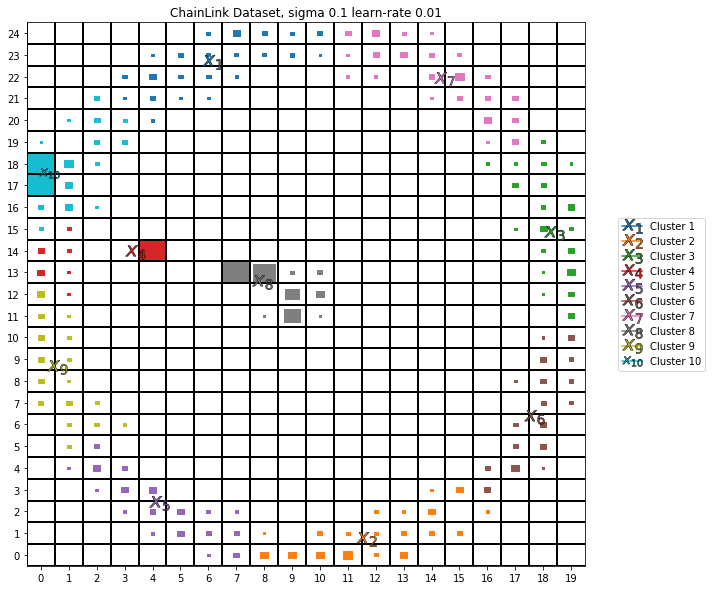

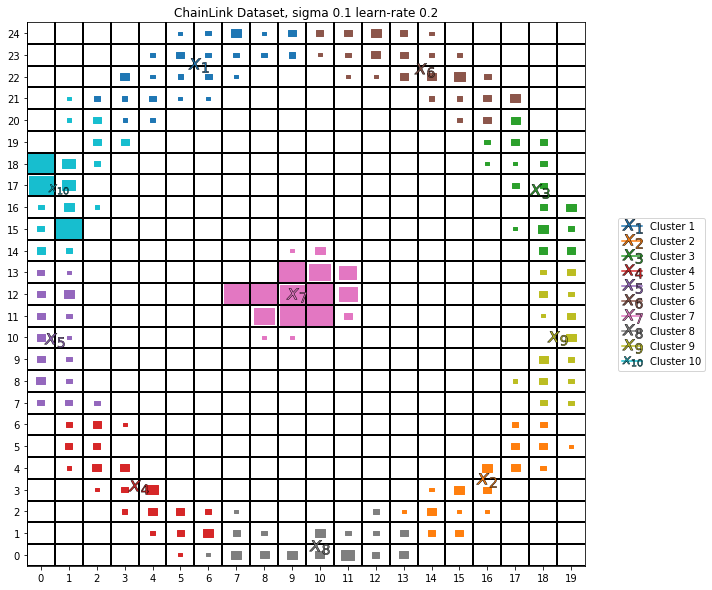

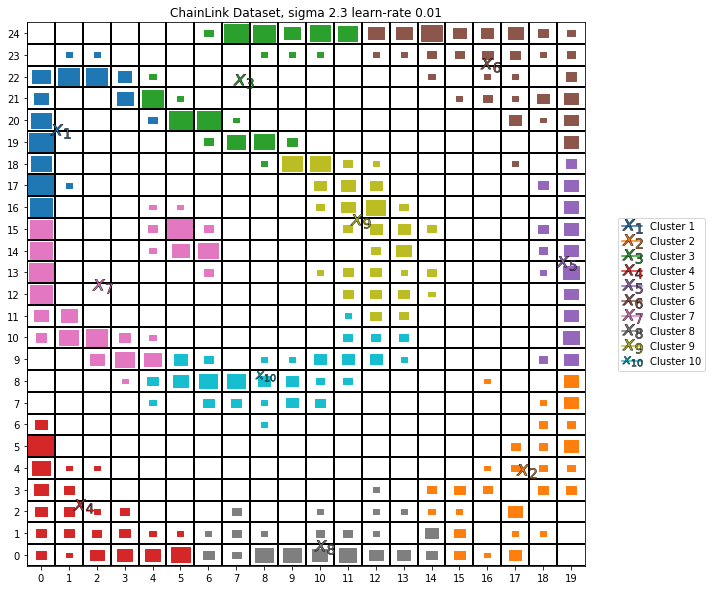

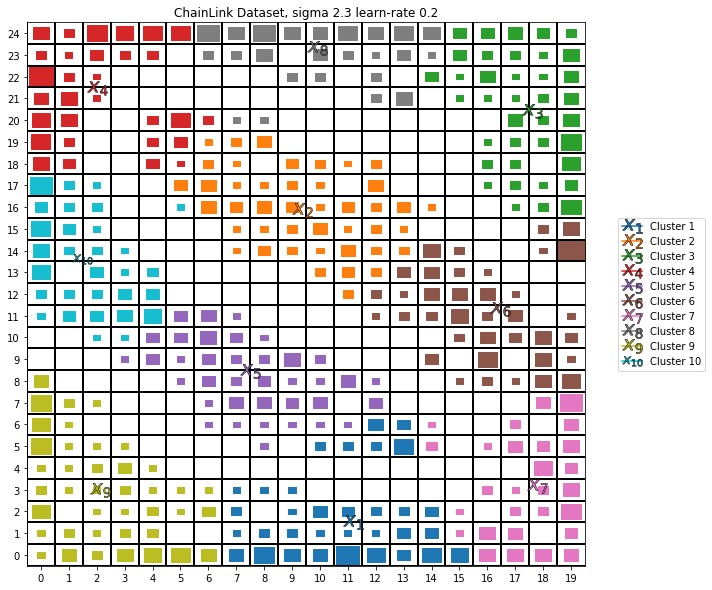

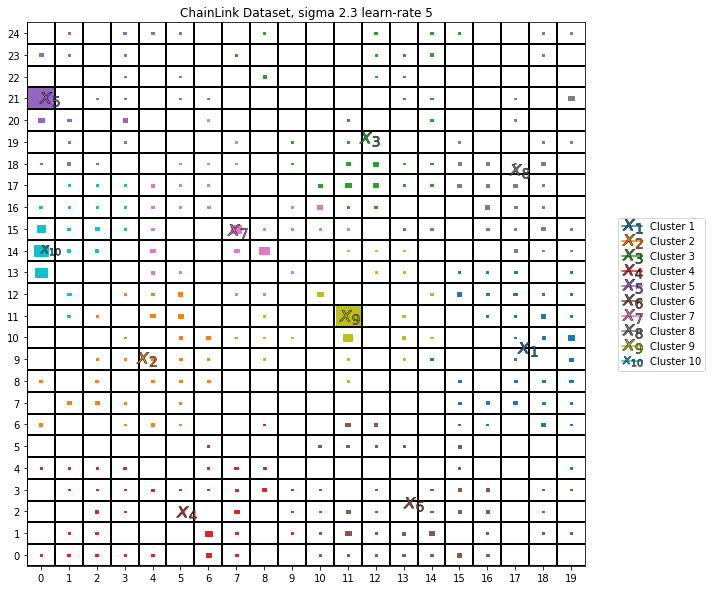

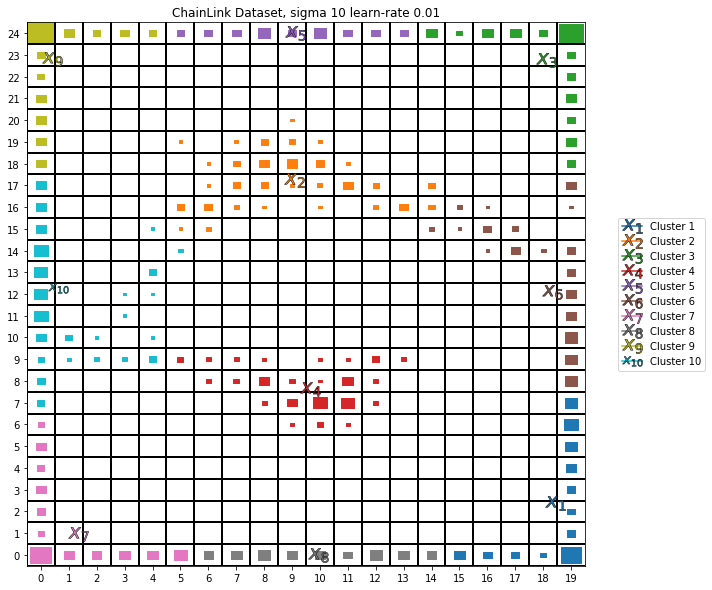

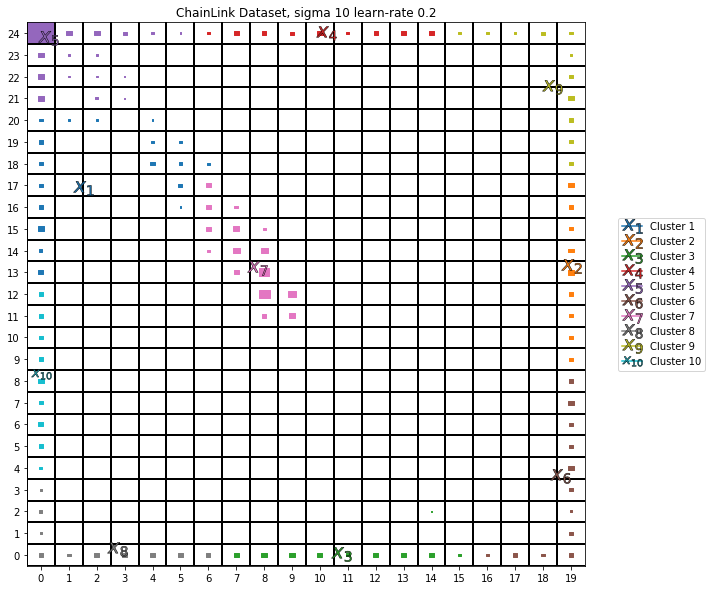

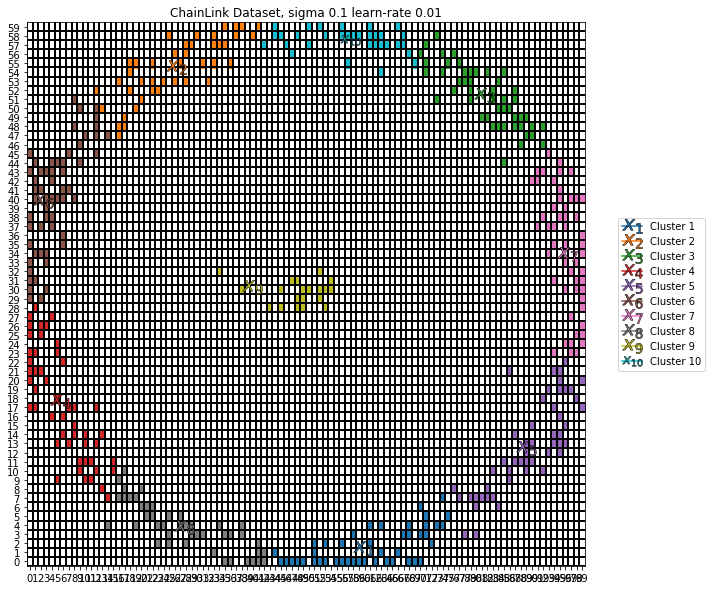

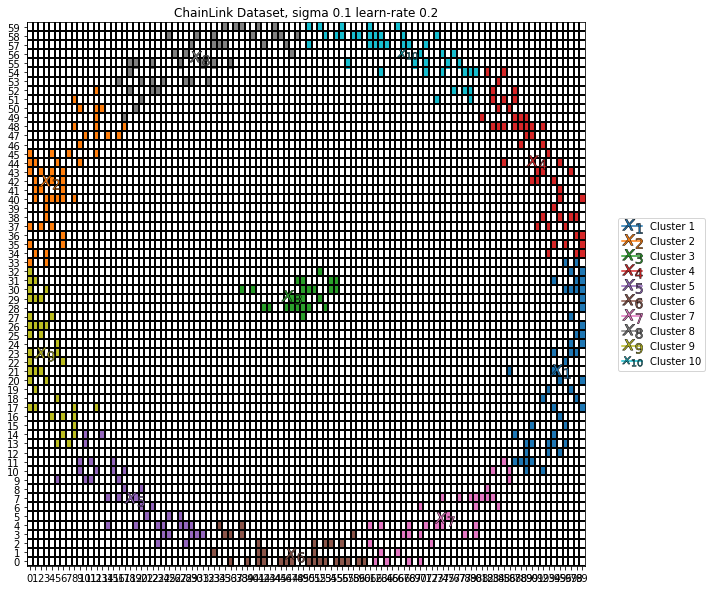

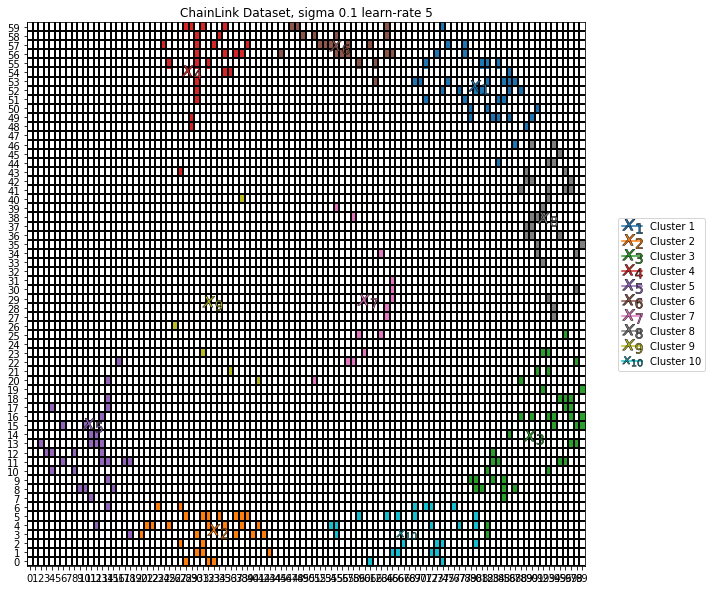

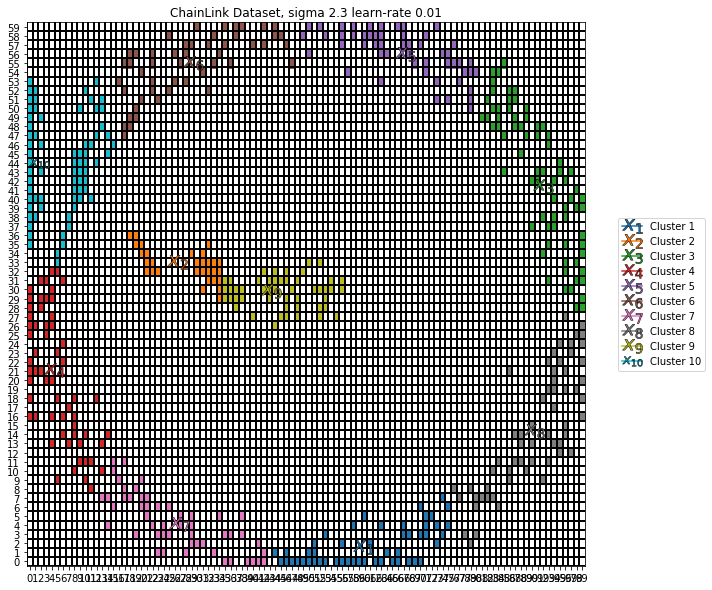

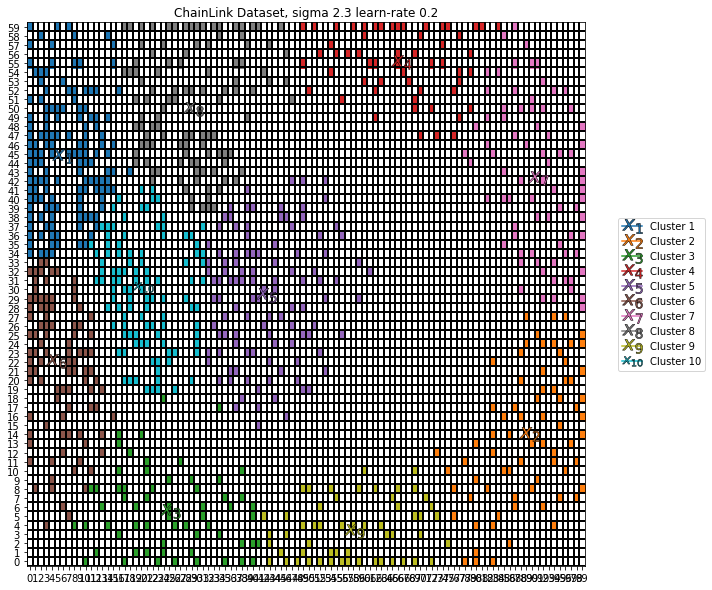

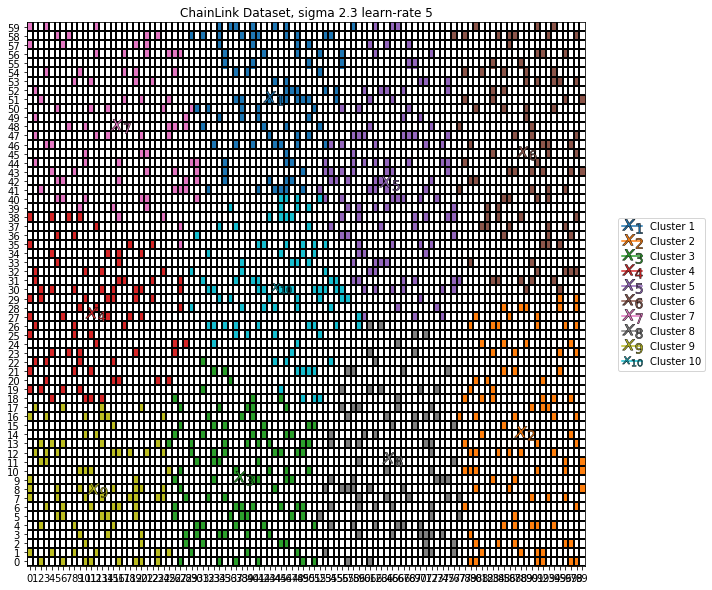

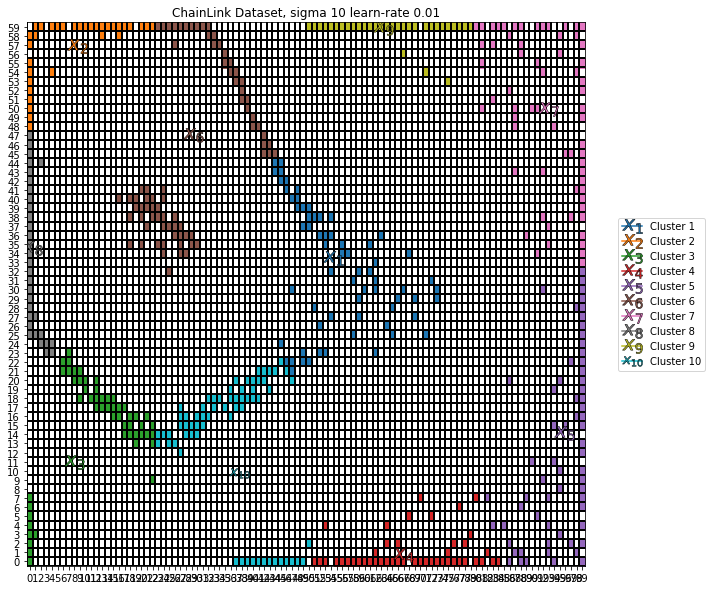

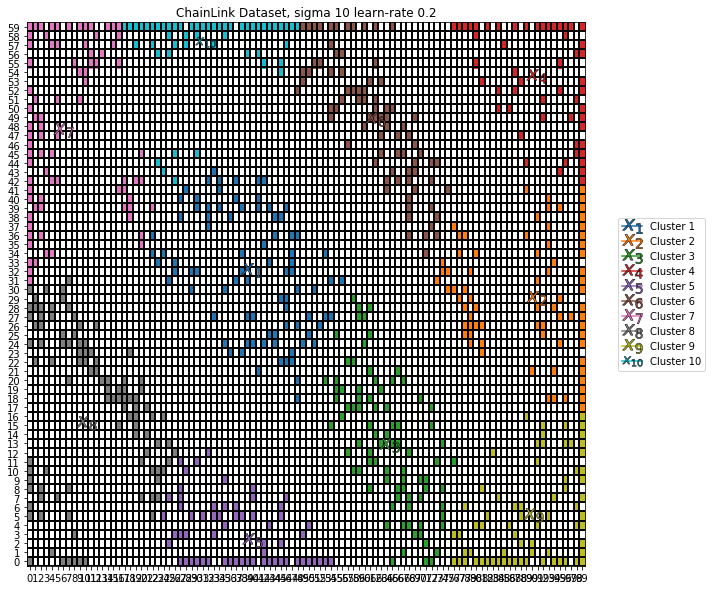

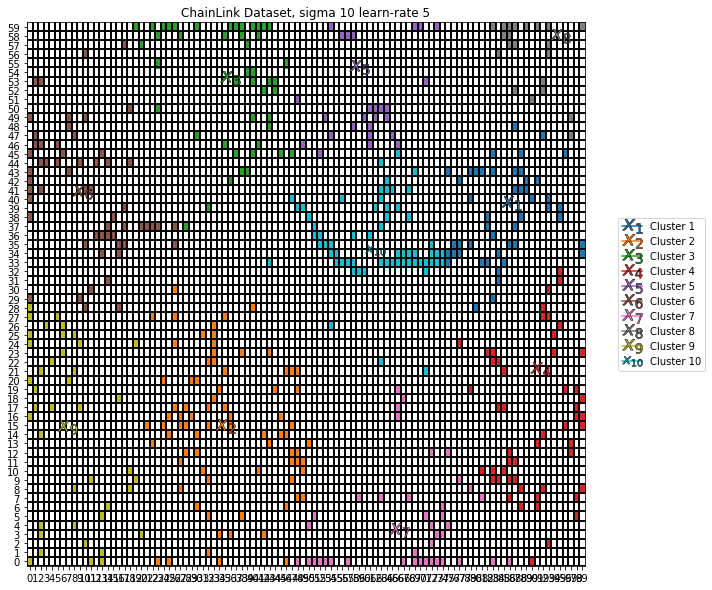

In [14]:
chainlink_kmeans_own = MyKMeansOnSOMLib(k=10, n_init=100, max_iter=10000, random_state=42)
for (x, y) in sizes:
    for sigma in sigmas:
        for learning_rate in learning_rates:
            chainlink_kmeans_own.load_files(
                filePath=path_chainlink_own.format(
                    x,
                    y,
                    sigma,
                    learning_rate
                ))
            try:
                chainlink_kmeans_own.fit()
                chainlink_kmeans_own.get_kmeans_plot(title="ChainLink Dataset, sigma {} learn-rate {}".format(sigma, learning_rate), grid=True, density=(x < 40) and (y < 40), link_clusters=False, threshold=1.2)
            except ValueError:
                print("The number of clusters is higher than the number of sampled -> can't be fitted")

### 10clusters

If the sigma wasn't high enough then it is possible that most points end up in the same cell and the k means algorithm can work with less datapoints than clusters.

Good viewable here is with the density indication that as in the SOM with sigma 10 and learn rate 0.01 the clusters are more spread around the map, but there are some cell with a very high density, but in for example the SOM with sigma 2.3 and learn rate 0.2 or 0.01 the points aren't that spread but the density is more evenly disributed.

Again for this dataset the differnt SOMs do not change the fact that the larger but not so dense cluster takes multiple k-means clusters and then some other separeted clusters share one k-means cluster.

The number of clusters is higher than the number of sampled -> can't be fitted
The number of clusters is higher than the number of sampled -> can't be fitted
The number of clusters is higher than the number of sampled -> can't be fitted
The number of clusters is higher than the number of sampled -> can't be fitted
The number of clusters is higher than the number of sampled -> can't be fitted
The number of clusters is higher than the number of sampled -> can't be fitted
The number of clusters is higher than the number of sampled -> can't be fitted
The number of clusters is higher than the number of sampled -> can't be fitted


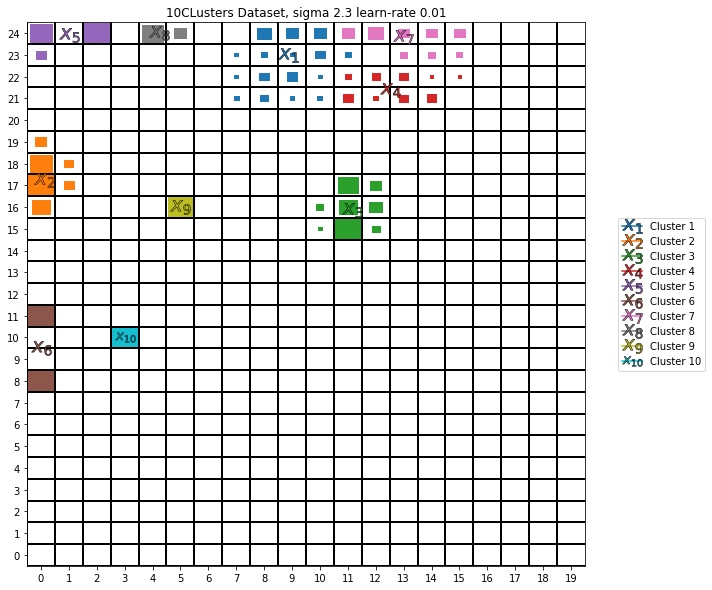

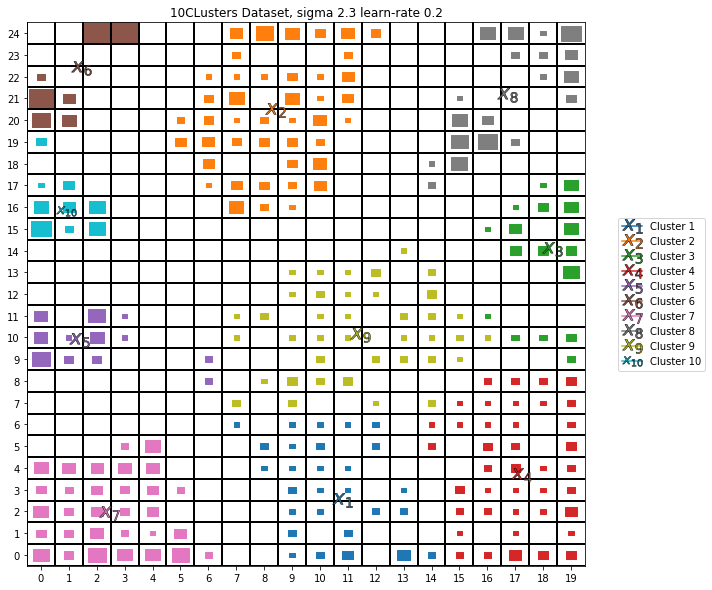

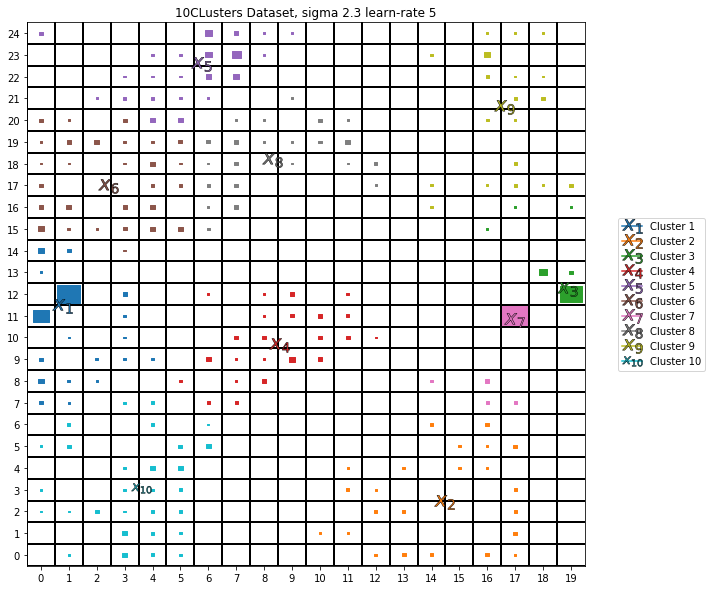

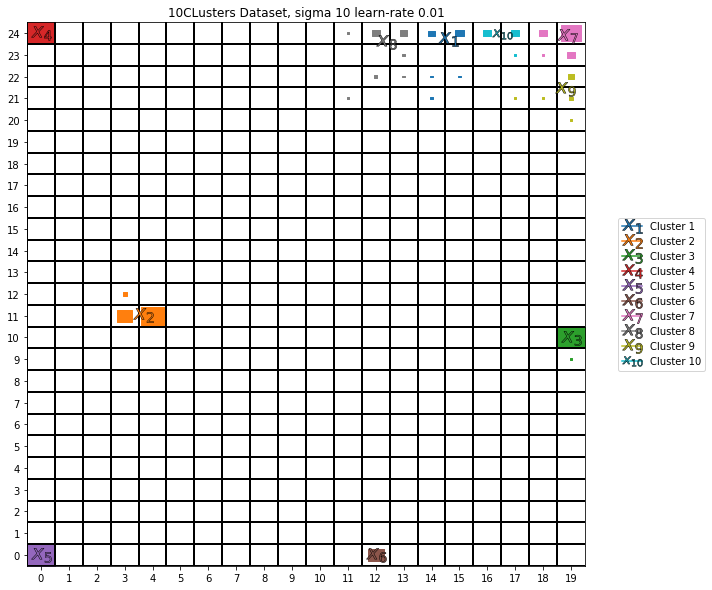

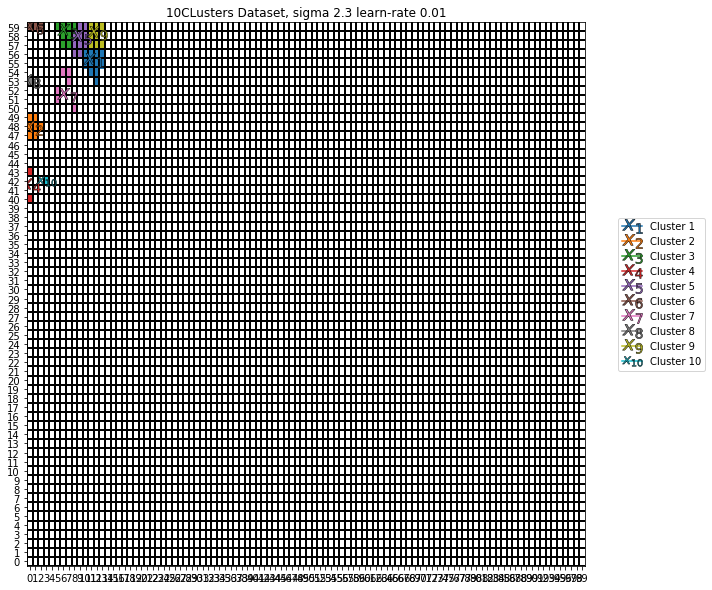

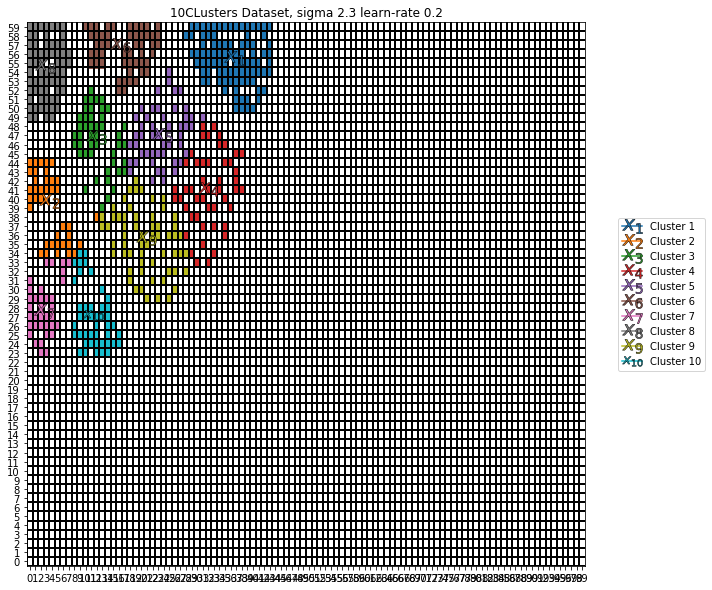

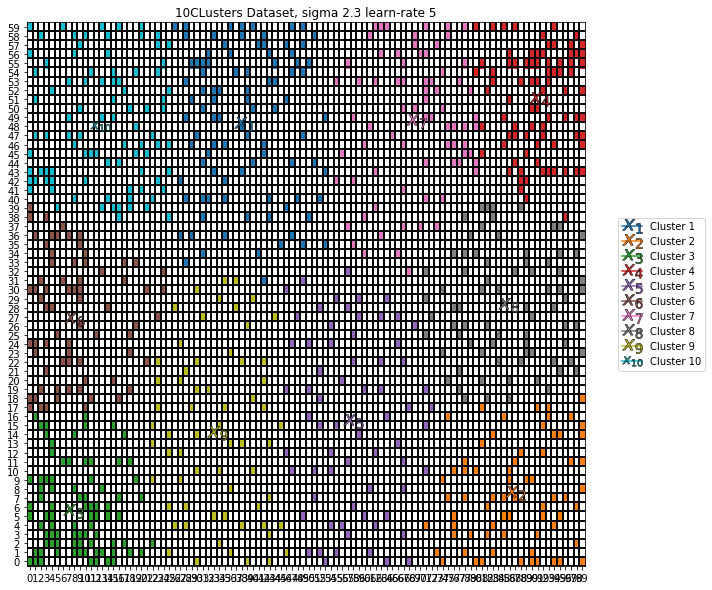

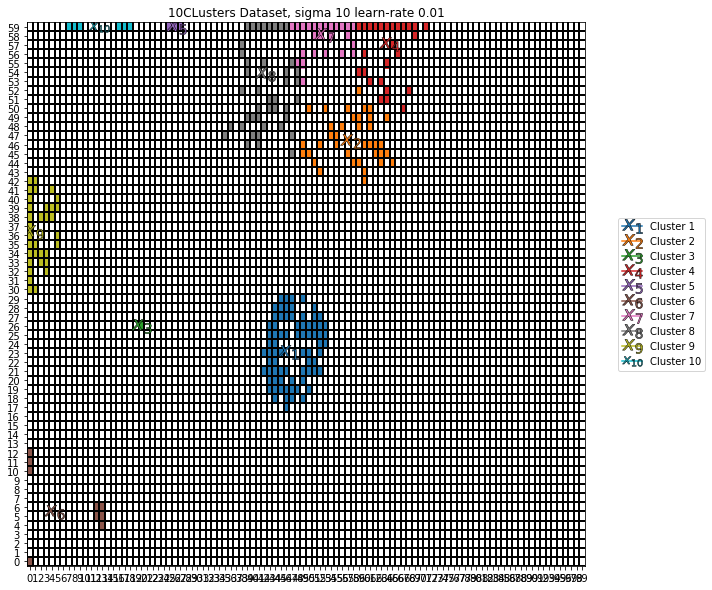

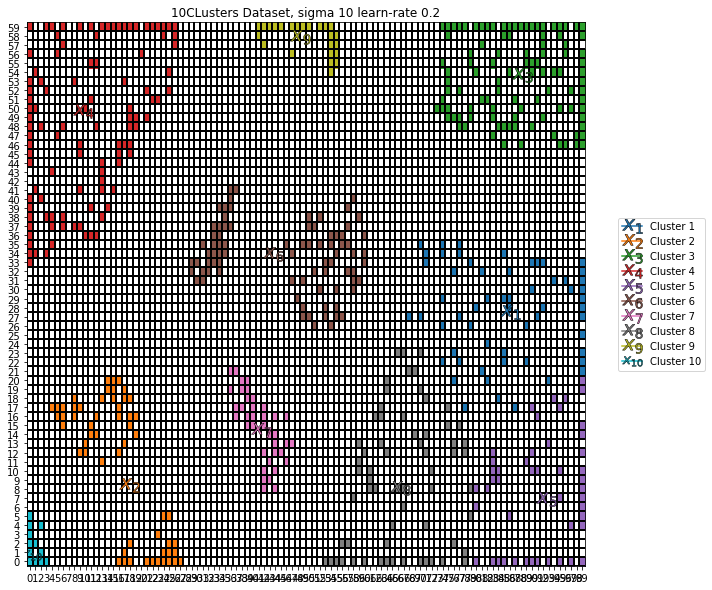

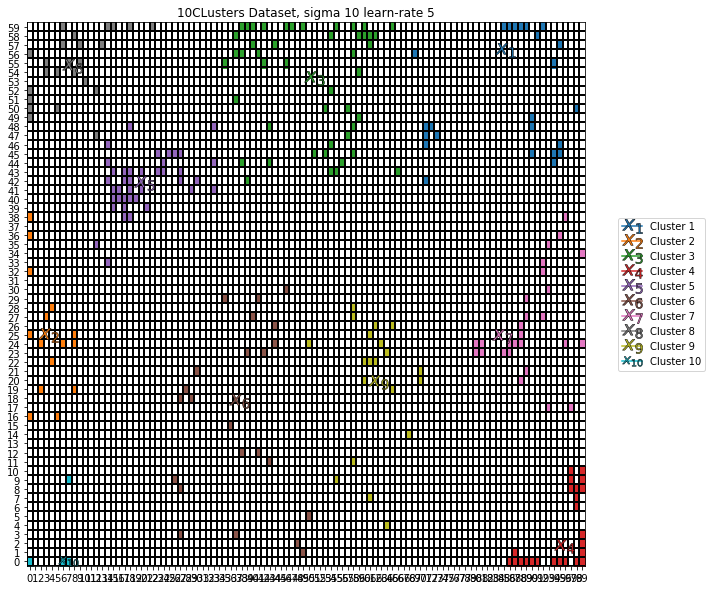

In [15]:
clusters10_kmeans_own = MyKMeansOnSOMLib(k=10, n_init=100, max_iter=10000, random_state=42)
for (x, y) in sizes:
    for sigma in sigmas:
        for learning_rate in learning_rates:
            clusters10_kmeans_own.load_files(
                filePath=path_10clusters_own.format(
                    x,
                    y,
                    sigma,
                    learning_rate
                ))
            try:
                clusters10_kmeans_own.fit()
                clusters10_kmeans_own.get_kmeans_plot(title="10CLusters Dataset, sigma {} learn-rate {}".format(sigma, learning_rate), grid=True, density=(x < 40) and (y < 40), link_clusters=False, threshold=1.2)
            except ValueError:
                print("The number of clusters is higher than the number of sampled -> can't be fitted")